# Residual Networks (ResNet) Tutorial in TensorFlow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


## Introduction to Residual Networks
ResNets revolutionized deep learning by introducing skip connections that enable training of very deep networks. This tutorial covers:
- Basic residual blocks (for ResNet-18/34)
- Bottleneck blocks (for ResNet-50/101/152)
- Complete implementations in TensorFlow/Keras
- Practical applications with pretrained models

---


## **ResNet-18**

### Basic Residual Block (For ResNet-18/34)

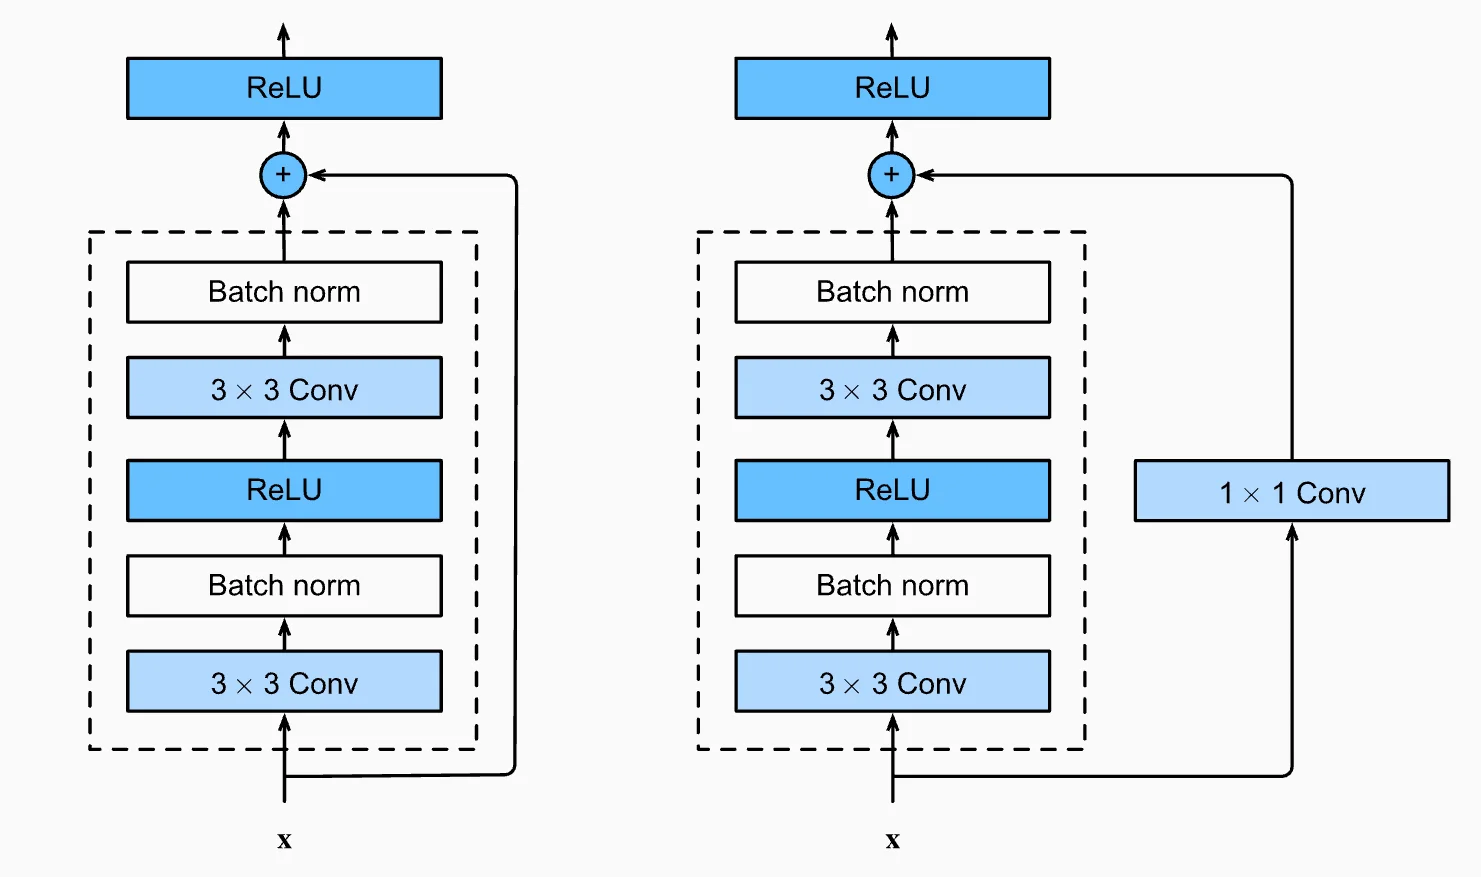

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add


def residual_block(x, filters, downsample=False):
    """
    Implements a basic Residual Block with two 3x3 convolution layers.

    Parameters:
    - x: Input tensor
    - filters: Number of filters for both conv layers
    - downsample: Whether to downsample using stride=2

    Returns:
    - Output tensor after applying the residual block
    """
    shortcut = x
    stride = 2 if downsample else 1

    # First convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    # Adjust shortcut if shape mismatch
    if downsample or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding="same")(
            shortcut
        )
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

In [3]:
# Usage Example:
inputs = tf.keras.Input(shape=(32, 32, 64))
x = residual_block(inputs, 128, downsample=False)

model = tf.keras.Model(inputs, x, name="Residual_Block")
# model.summary()

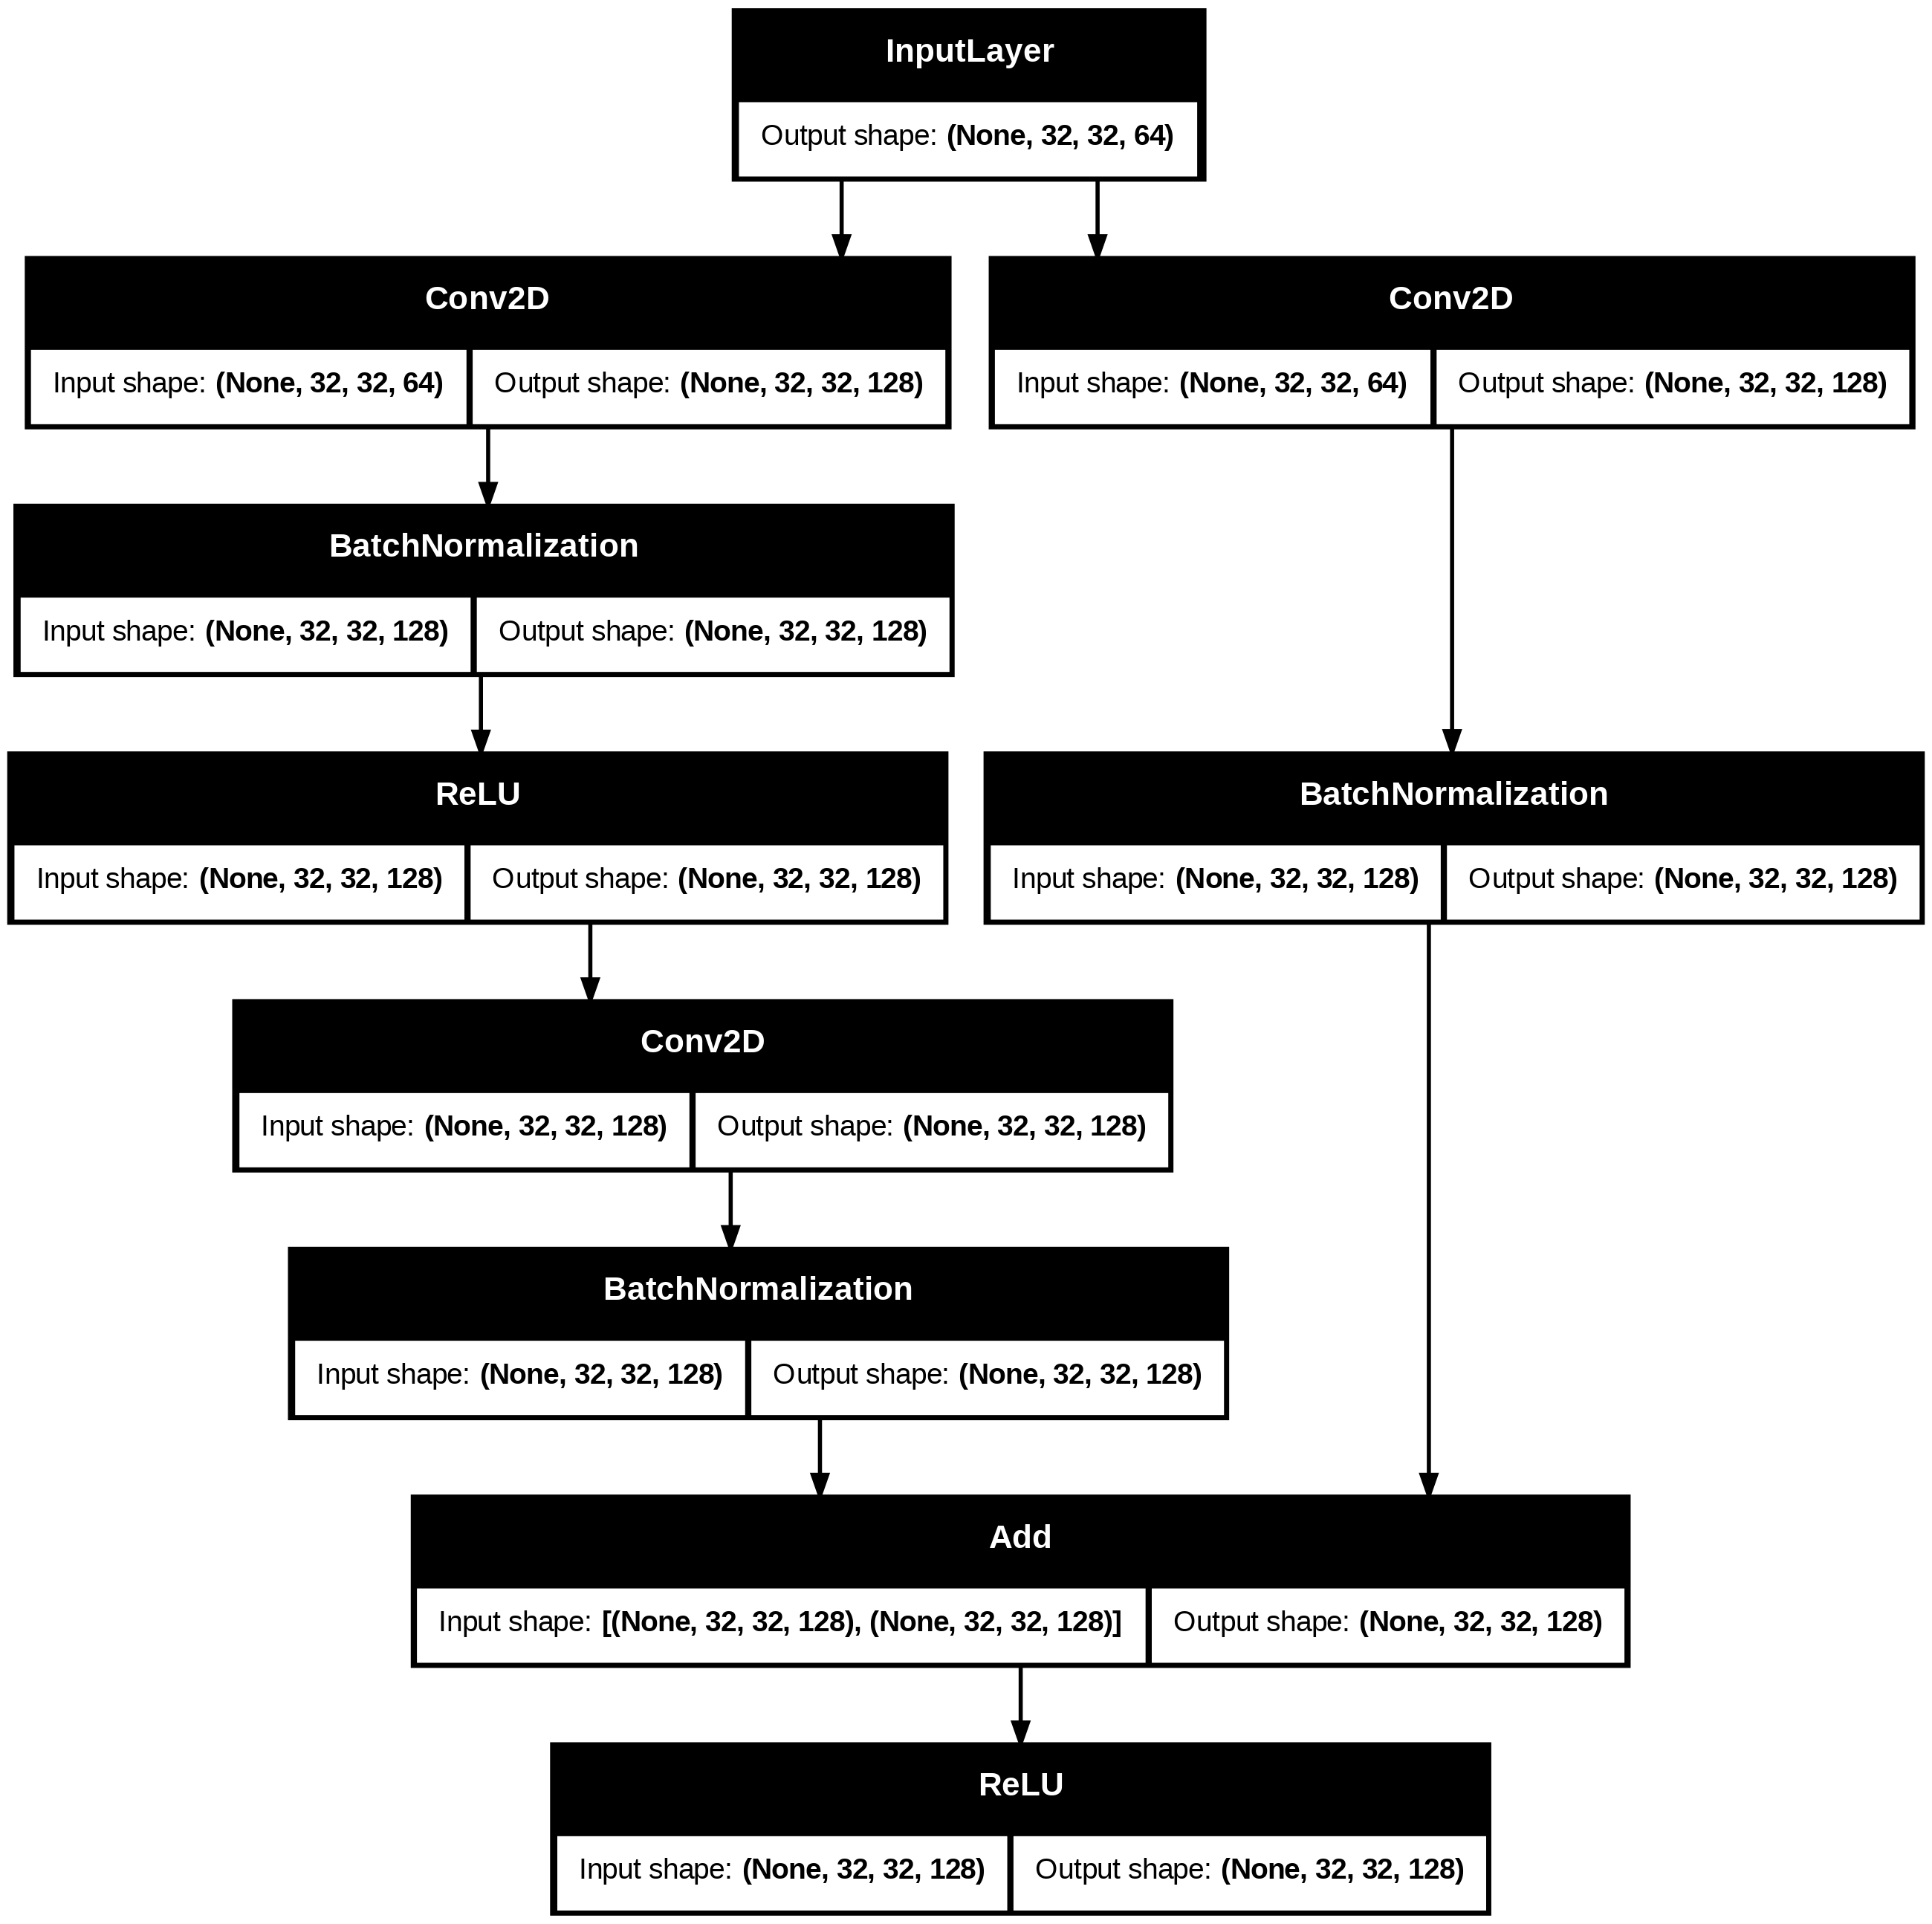

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="Residual_Block.png", show_shapes=True)

---

### ResNet-18 Architecture Overview


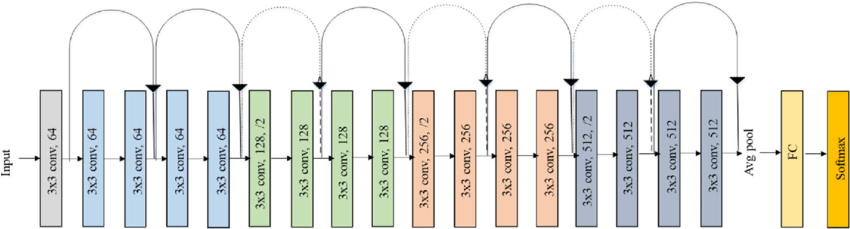


ResNet-18 is the smallest variant of the Residual Network family, designed for efficiency while maintaining strong performance. It consists of **18 layers** (counting only weighted layers like convolutions and fully connected layers).

**Technical Specifications**
| Feature            | Specification          |
|--------------------|------------------------|
| Total Layers       | 18 (weighted)          |
| Parameters         | ~11 million           |
| Input Size         | 224×224×3 (default)   |
| Ideal Use Cases    | CIFAR-10/100, Tiny-ImageNet, edge devices |

**Layer-by-Layer Breakdown**
| Stage | Component          | Configuration           | Output Size  | Key Details                  |
|-------|--------------------|-------------------------|--------------|------------------------------|
| **1** | Input Layer        | -                       | 224×224×3    | RGB image input              |
| **1** | Initial Convolution| 7×7, 64 filters, stride=2 | 112×112×64  | + BatchNorm + ReLU           |
| **1** | Max Pooling        | 3×3, stride=2           | 56×56×64     | Padding='same'               |
| **2** | Residual Block ×2  | 3×3, 64 filters         | 56×56×64     | Identity shortcut            |
| **3** | Residual Block ×2  | 3×3, 128 filters        | 28×28×128    | Downsampling in first block  |
| **4** | Residual Block ×2  | 3×3, 256 filters        | 14×14×256    | Downsampling in first block  |
| **5** | Residual Block ×2  | 3×3, 512 filters        | 7×7×512      | Downsampling in first block  |
| **6** | Classification     | Global Avg Pool → FC    | num_classes  | Softmax activation           |


---

### Complete ResNet-18 Implementation

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    ReLU,
    MaxPooling2D,
    GlobalAvgPool2D,
    Dense,
)


def build_resnet18(input_shape=(224, 224, 3), num_classes=1000):

    # Stage-1: Initial layers
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Residual blocks
    # Stage-2 (no downsampling)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # Stage-3
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    # Stage-4
    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)

    # Stage-5
    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)

    # Stage-6: Classification head
    x = GlobalAvgPool2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs, name="ResNet18")

---

### Training ResNet18 on CIFAR-10

In [6]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


In [ ]:
# Preprocess CIFAR-10
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
# Define ResNet18 Model
model = build_resnet18(input_shape=(32, 32, 3), num_classes=10)

# Compile Model
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Train Model
epochs = 5
batch_size = 256
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
)

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.4055 - loss: 1.8122 - val_accuracy: 0.1689 - val_loss: 2.7910
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.6066 - loss: 1.1061 - val_accuracy: 0.4281 - val_loss: 1.8724
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6966 - loss: 0.8636 - val_accuracy: 0.6278 - val_loss: 1.1110
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7435 - loss: 0.7239 - val_accuracy: 0.5884 - val_loss: 1.4365
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7844 - loss: 0.6102 - val_accuracy: 0.6145 - val_loss: 1.2202


---

## **ResNet-50**

### Bottleneck Block (For ResNet-50/101/152)

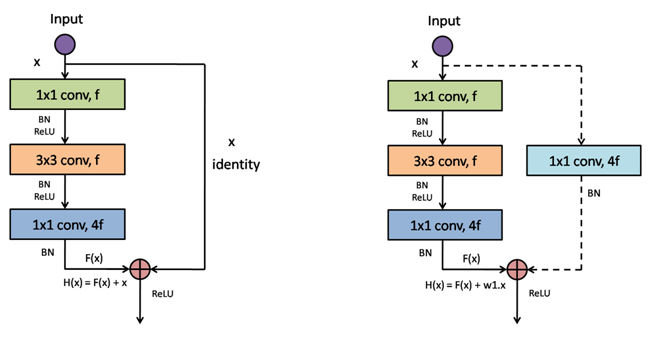

```
Input  
  │  
1x1 Conv (Reduce-Channels)       ←  Dimensionality reduction  
  │  
3x3 Conv (Same-Channels)         ←  Feature extraction  
  │  
1x1 Conv (Expand-Channels)       ←  Dimensionality expansion  
  │  
+ Skip Connection 
  │  
ReLU  
```

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add
import tensorflow as tf


def bottleneck_block(x, filters, downsample=False):
    """
    Bottleneck block used in ResNet-50/101/152 with optional verbose printing of shapes.

    Parameters:
    - x: input tensor
    - filters: number of filters for the bottleneck (before expansion)
    - downsample: whether to apply stride=2 to downsample

    Returns:
    - Output tensor after applying the bottleneck block
    """

    shortcut = x
    stride = 2 if downsample else 1
    expansion = 4  # ResNet expands channels by 4 in bottleneck

    # First conv (1x1, reduce channels)
    x = Conv2D(filters, kernel_size=1, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second conv (3x3, same channels)
    x = Conv2D(filters, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third conv (1x1, expand channels)
    x = Conv2D(filters * expansion, kernel_size=1, strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut if needed
    if downsample or shortcut.shape[-1] != filters * expansion:
        shortcut = Conv2D(
            filters * expansion, kernel_size=1, strides=stride, padding="same"
        )(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

In [40]:
# Usage Example:
inputs = tf.keras.Input(shape=(32, 32, 128))
x = bottleneck_block(inputs, filters=64, downsample=True)

model = tf.keras.Model(inputs, x, name="Bottleneck_Block")
# model.summary()

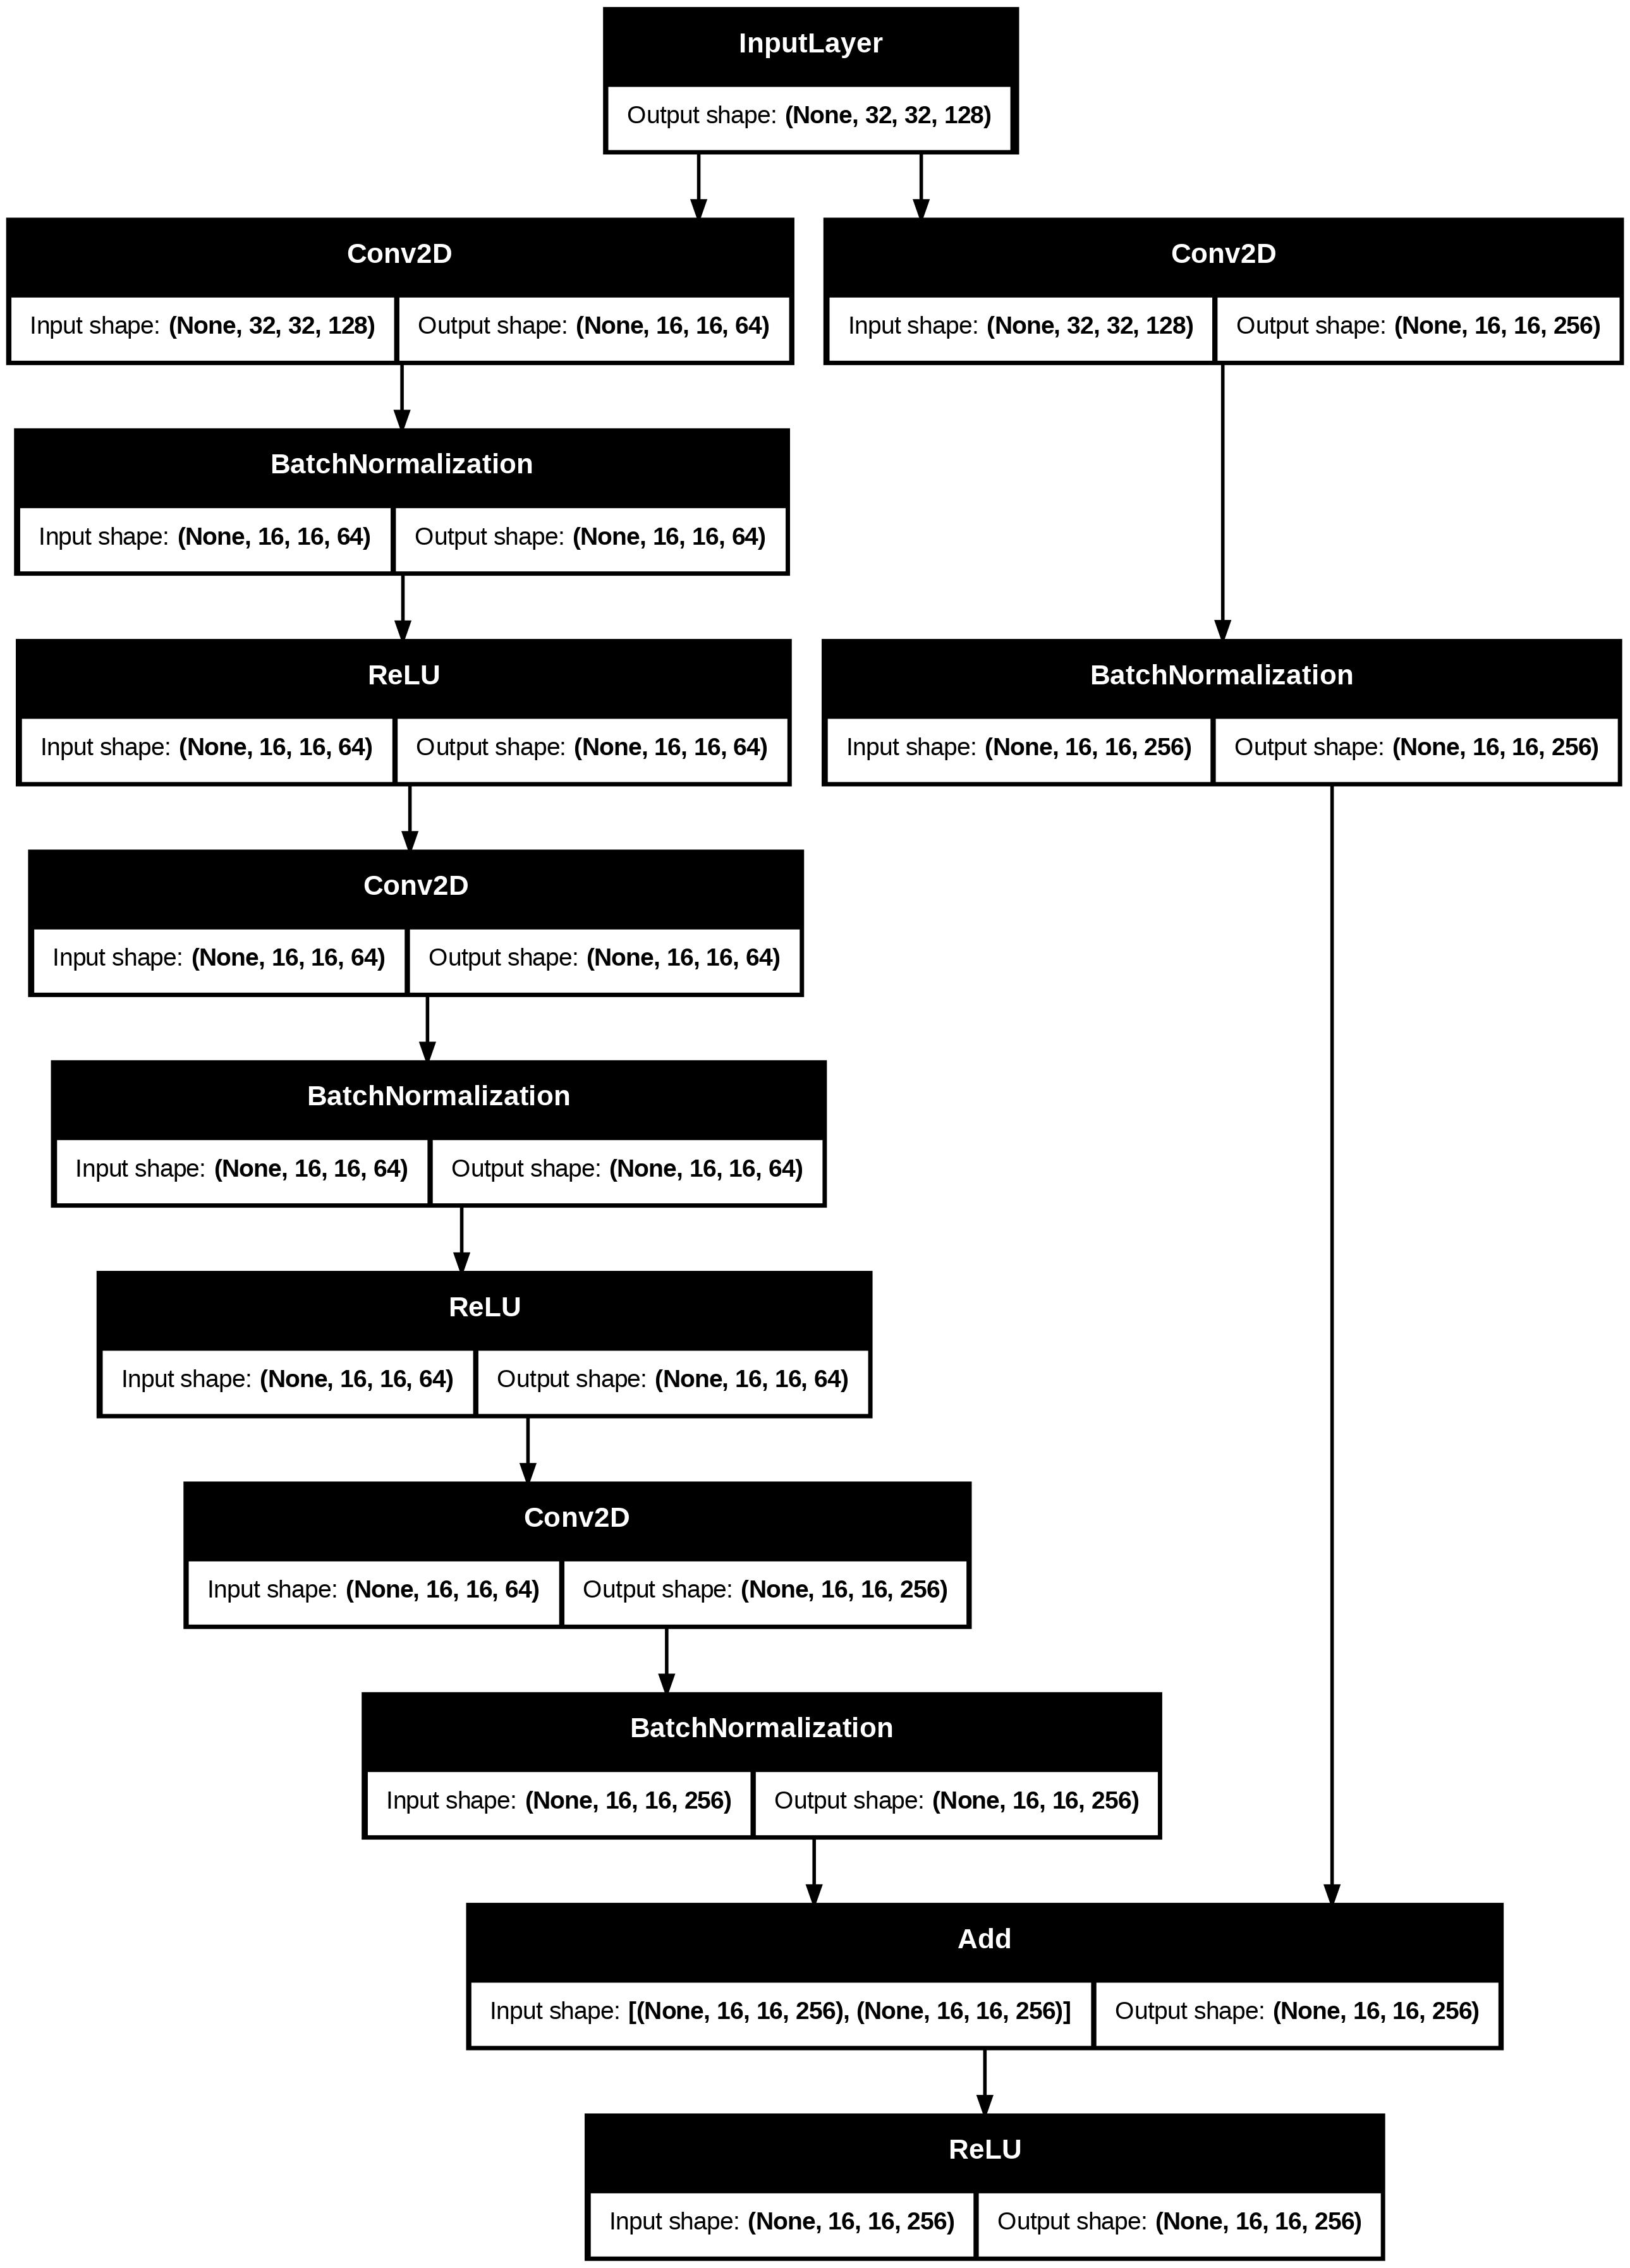

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="Bottleneck_Block.png", show_shapes=True)

---

### ResNet-50 Architecture Overview


ResNet-50 introduced the **bottleneck block** design, enabling deeper networks (50 layers) while maintaining computational efficiency. It became the standard backbone for computer vision tasks.

**Technical Specifications**
| Feature            | Specification          |
|--------------------|------------------------|
| Total Layers       | 50 (weighted)          |
| Parameters         | ~25.6 million         |
| Input Size         | 224×224×3 (default)   |
| Ideal Use Cases    | ImageNet, large-scale tasks, feature extraction |

**Layer-by-Layer Breakdown**
| Stage | Component             | Configuration                  | Output Size  | Key Details                  |
|-------|-----------------------|--------------------------------|--------------|------------------------------|
| **1** | Input Layer           | -                              | 224×224×3    | RGB image input              |
| **1** | Initial Convolution   | 7×7, 64 filters, stride=2      | 112×112×64   | + BatchNorm + ReLU           |
| **1** | Max Pooling           | 3×3, stride=2                  | 56×56×64     | Padding='same'               |
| **2** | Bottleneck Block ×3   | [1×1,64]<br>[3×3,64]<br>[1×1,256] | 56×56×256    | Expansion=4                  |
| **3** | Bottleneck Block ×4   | [1×1,128]<br>[3×3,128]<br>[1×1,512] | 28×28×512    | Downsample 1st block         |
| **4** | Bottleneck Block ×6   | [1×1,256]<br>[3×3,256]<br>[1×1,1024] | 14×14×1024   | Downsample 1st block         |
| **5** | Bottleneck Block ×3   | [1×1,512]<br>[3×3,512]<br>[1×1,2048] | 7×7×2048     | Downsample 1st block         |
| **6** | Classification        | Global Avg Pool → FC           | num_classes  | Softmax activation           |

**Bottleneck Blocks**:
   ```
   1×1 conv (channel reduction)
   ↓
   3×3 conv (spatial features)
   ↓ 
   1×1 conv (channel expansion)
   ↓
   + Skip Connection 
   ↓
   ReLU
   ```


---

### Complete ResNet-50 Implementation

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    ReLU,
    MaxPooling2D,
    GlobalAvgPool2D,
    Dense,
)


def build_resnet50(input_shape=(224, 224, 3), num_classes=1000):
    inputs = Input(shape=input_shape)

    # Stage-1: Initial layers
    x = Conv2D(64, 7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Stage-2: 3 Bottleneck blocks with 64 filters
    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 64)

    # Stage-3: 4 Bottleneck blocks with 128 filters (downsample first)
    x = bottleneck_block(x, 128, downsample=True)
    x = bottleneck_block(x, 128)
    x = bottleneck_block(x, 128)
    x = bottleneck_block(x, 128)

    # Stage-4: 6 Bottleneck blocks with 256 filters (downsample first)
    x = bottleneck_block(x, 256, downsample=True)
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)

    # Stage-5: 3 Bottleneck blocks with 512 filters (downsample first)
    x = bottleneck_block(x, 512, downsample=True)
    x = bottleneck_block(x, 512)
    x = bottleneck_block(x, 512)

    # Stage-6: Final layers
    x = GlobalAvgPool2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs, name="ResNet50")

---

## **Practical Applications**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

### Using Pretrained ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
# Load pretrained ResNet50 model
model = ResNet50(weights="imagenet")

--2025-04-22 04:00:50--  https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2833605 (2.7M) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]   2.70M  --.-KB/s    in 0.09s   

2025-04-22 04:00:50 (29.0 MB/s) - ‘cat.jpg’ saved [2833605/2833605]



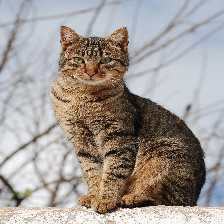

In [35]:
# Load Image
!wget "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg" -O "cat.jpg"

img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img

In [25]:
# Preprocess Image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [26]:
# Predict
preds = model.predict(x)
print("Predicted:")
decode_predictions(preds, top=3)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Predicted:


[('n02123159', 'tiger_cat', np.float32(0.48983595)),
 ('n02123045', 'tabby', np.float32(0.23457623)),
 ('n02124075', 'Egyptian_cat', np.float32(0.097449556))]

---

### Feature Extraction using ResNet50 (without classification head)

In [ ]:
# Load ResNet50 without the top layer

base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# OR

base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
model = Model(inputs=base_model.input, outputs=base_model.output)

In [47]:
# Extract features
features = model.predict(x)
print("Feature vector shape:", features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Feature vector shape: (1, 2048)


---